In [1]:
import os
import mne
import pandas as pd
import pickle
import numpy as np
from scipy import linalg, stats
from mne import io
from mne.connectivity import spectral_connectivity
import winsound
import warnings
import re
from mne.channels import find_ch_connectivity
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import lil_matrix

In [2]:
#Functions

def makeSound(freq = 6000, # Hz
              duration = 3000): # millisecond
    #import winsound
    winsound.Beep(freq, duration)

def readPythonObject(path):
    #import pickle
    infile = open(path,'rb')
    objectName = pickle.load(infile)
    infile.close()
    return objectName


Loading needed variables for questions.

**The data files can be found here:**
https://www.dropbox.com/sh/ik6hmp0b09c3l8f/AABsZ0uSp5AR2GK70XUGk4Vta?dl=0

In [3]:
#Sample data I use to get information like channels names, etc.
combinedBaseline = readPythonObject("EEG question data/combinedBaseline.pkl")
#My calculated connections
conns = readPythonObject("EEG question data/conns.pkl")
#Sensors location settings for the first cap
locations = readPythonObject("EEG question data/locations.pkl")
#Sensors location settings for the two caps
locationSettings = readPythonObject("EEG question data/locationSettings.pkl")
sens_loc = readPythonObject("EEG question data/sens_loc.pkl")
#Additional data
from sklearn.externals import joblib
combinedList = joblib.load("EEG question data/combinedList.pkl")

Calculating data for sparse matrix

In [4]:
#Calculating the number of combinations in the lower matrix trig
nchan = int(len(combinedBaseline.info["ch_names"]))
bin=0
idx = []
electrodes = []
for e1 in range(nchan):
    for e2 in range(nchan):
        if e2>e1:
            idx.append(bin)
            electrodes.append((e1, e2))
        bin = bin + 1

print(len(idx))
print(len(electrodes))
if (nchan**2 - nchan) / 2 == len(idx): 
    print(len(idx))

1891
1891
1891


The frequency bands I use

In [5]:
freqbands = {'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 60)}

Creating 3D ndarray for the connections between the vectors (subject, freq, connections)

In [6]:
frequencies_labels = list(freqbands.keys())
vectconn = np.zeros([len(conns), len(frequencies_labels), len(idx)])
for f_idx, f_lab in enumerate(frequencies_labels):
    for s_idx, s_conn in enumerate(conns):
        vectconn[s_idx, f_idx, :] = s_conn[idx, f_idx]
print("The shape of vectoconn is:", vectconn.shape)

The shape of vectoconn is: (139, 3, 1891)


In order to calculate the distances between close channels, I shifted the location of the second cap by 0.0000001

**Is there a better way to do that?**

In [7]:
#change sensors locations as if cap1 and cap2 are at the same position
#but with a shift of 0.0000001 for the second cap
for i, v in enumerate(zip(locations[31:], [ch['loc'] for ch in combinedBaseline.info['chs']][31:])):
    p = i + 31
    combinedBaseline.info["chs"][p]['loc'] = v[0] + 0.0000001

In [8]:
print(combinedBaseline.info["chs"][0]["loc"][0:3])
print(combinedBaseline.info["chs"][31]["loc"][0:3])

[-0.0294367  0.0839171 -0.00699  ]
[-0.0294366  0.0839172 -0.0069899]


Creating sprase matrix

**BUG? - Am I creating it correctly?**

I'm not sure it calculates the clusters correctly. 

In [9]:
#Creating matrix for sparse matrix
A = find_ch_connectivity(combinedBaseline.info, ch_type="eeg")
metaconn = np.zeros((vectconn.shape[-1], vectconn.shape[-1]))
for ne1, (e11,e12) in tqdm(enumerate(electrodes)):
    for ne2, (e21,e22) in enumerate(electrodes):
        metaconn[ne1, ne2] = (((A[0][e11,e21]) and (A[0][e12,e22])) or 
                              ((A[0][e11,e22]) and (A[0][e12,e21])) or
                              ((A[0][e11,e21]) and (e12 == e22)) or 
                              ((A[0][e12,e21]) and (e11 == e22)) or
                              ((A[0][e11,e22]) and (e12 == e21)) or 
                              ((A[0][e12,e22]) and (e11 == e21)))

vectconn.shape[-1]
makeSound()

Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 62


1891it [11:12,  2.84it/s]


Reversing location settings

In [10]:
for old, new in enumerate(sens_loc):
    combinedBaseline.info["chs"][old]["loc"][0:3] = new[0:3]

Testing the sparse marix

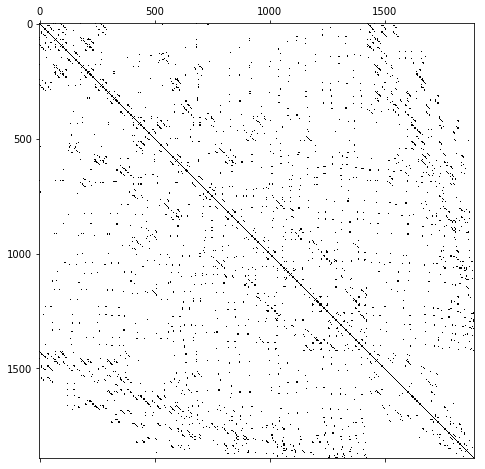

In [11]:
#Plot for sparse matrix of connections
plt.figure(figsize=[10,8])
plt.spy(metaconn)
plt.show()

Testing location between sensors

***BUG? - I'm not sure that it took all the close connections***

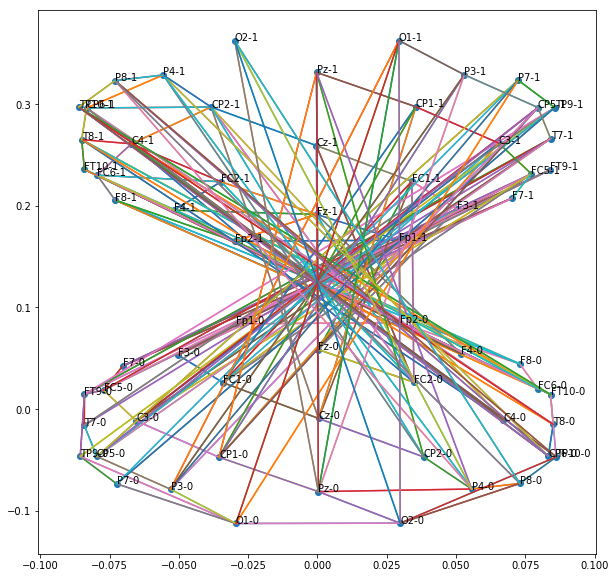

In [12]:
# Check sensors neighborood for all connections
sensloc = np.array([c['loc'][:3] for c in combinedBaseline.info['chs']][:62])
plt.figure(figsize=[10,10])
plt.scatter(sensloc[:, 0], sensloc[:, 1])
for i, txt in enumerate(combinedBaseline.info["ch_names"]):
        plt.annotate(combinedBaseline.info["ch_names"][i], (sensloc[i, 0], sensloc[i, 1]))
for e1 in range(62):
    for e2 in range(62):
        if A[0][e1,e2]:
            plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1], sensloc[e2, 1]))

Adding group value to vectconn

In [13]:
grps = np.zeros(vectconn.shape[0])
count = -1
for s_idx, c in tqdm(enumerate(combinedList)):
    for i, cSub in enumerate(c[1]):
        count +=1
#        print(cSub[i].info["subject_info"]["ID"])
        if cSub[i].info["subject_info"]["ID"][1] == "1" and cSub[i].info["subject_info"]["active"] == "m":
            grps[count] = 1
        elif cSub[i].info["subject_info"]["ID"][1] == "1" and cSub[i].info["subject_info"]["active"] == "f":
            grps[count] = 2
        elif cSub[i].info["subject_info"]["ID"][1] == "2" and cSub[i].info["subject_info"]["active"] == "m":
            grps[count] = 3
        elif cSub[i].info["subject_info"]["ID"][1] == "2" and cSub[i].info["subject_info"]["active"] == "f":
            grps[count] = 4
        elif cSub[i].info["subject_info"]["ID"][1] == "3" and cSub[i].info["subject_info"]["active"] == "m":
            grps[count] = 5
        elif cSub[i].info["subject_info"]["ID"][1] == "3" and cSub[i].info["subject_info"]["active"] == "f":
            grps[count] = 6
            
print("Number of male couples:", len([i for i in grps.tolist() if i == 1]))
print("Number of female couples:", len([i for i in grps.tolist() if i == 2]))
print("Number of male best friends:", len([i for i in grps.tolist() if i ==3]))
print("Number of female best friends:", len([i for i in grps.tolist() if i ==4]))
print("Number of male strangers:", len([i for i in grps.tolist() if i ==5]))
print("Number of female strangers:", len([i for i in grps.tolist() if i ==6]))

70it [00:01, 45.91it/s]


Number of male couples: 26
Number of female couples: 27
Number of male best friends: 14
Number of female best friends: 14
Number of male strangers: 29
Number of female strangers: 29


**Calculating permutation *without clusters***
It actually have an automatic clustering system. 

**BUG? - Why do I get those errors? and why it uses 1 tailed?**

In [14]:
fobsList = []
clustersList = []
cluster_pvList = []
H0List = []
pvalue = 0.05
for f_idx, f_lab in enumerate(frequencies_labels):
    print(f_idx, f_lab)
    data1 = vectconn[np.argwhere(grps==1), f_idx, :]
    data2 = vectconn[np.argwhere(grps==2), f_idx, :]
    data3 = vectconn[np.argwhere(grps==3), f_idx, :]
    data4 = vectconn[np.argwhere(grps==4), f_idx, :]
    data5 = vectconn[np.argwhere(grps==5), f_idx, :]
    data6 = vectconn[np.argwhere(grps==6), f_idx, :]
    romantic = np.concatenate([data1, data2], axis = 0)
    goodFriends = np.concatenate([data3, data4], axis = 0)
    strangers = np.concatenate([data5, data6], axis = 0)
    Fobs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(X=[romantic, strangers, goodFriends],
                                                                        tail=0,
                                                                        n_permutations = 1000,
                                                                        seed = 42, 
                                                                        step_down_p = pvalue,
                                                                        connectivity = None,
                                                                        check_disjoint = False)
    fobsList.append(Fobs)
    clustersList.append(clusters)
    cluster_pvList.append(cluster_pv)
    H0List.append(H0)

0 alpha


<ipython-input-14-a9e3e39be56f>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.000012 max=16.716287
Running initial clustering
Found 283 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
1 beta


<ipython-input-14-a9e3e39be56f>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.000110 max=13.907695
Running initial clustering
Found 318 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
2 gamma


<ipython-input-14-a9e3e39be56f>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.000648 max=19.980765
Running initial clustering
Found 311 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 33 clusters to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 5 additional clusters to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Done.


**How many p-values I have for each band**

I have 38 significant clusters in gamma?! 

In [15]:
for c, p in enumerate(cluster_pvList):
    print("for freq", frequencies_labels[c], "I have" , len([pv for pv in p if pv < pvalue]), "pvs")
    print("for freq", frequencies_labels[c], "pv values" , [pv for pv in p if pv < pvalue])

for freq alpha I have 2 pvs
for freq alpha pv values [0.021, 0.036]
for freq beta I have 2 pvs
for freq beta pv values [0.025, 0.024]
for freq gamma I have 38 pvs
for freq gamma pv values [0.007, 0.024, 0.001, 0.039, 0.036, 0.017, 0.023, 0.002, 0.003, 0.021, 0.036, 0.025, 0.023, 0.024, 0.027, 0.003, 0.002, 0.015, 0.015, 0.033, 0.027, 0.008, 0.004, 0.011, 0.008, 0.006, 0.003, 0.003, 0.027, 0.025, 0.003, 0.025, 0.046, 0.002, 0.036, 0.006, 0.018, 0.011]


Graphing the significant connections

**BUG? - I find it a bit odd that it only one sided - from subject one to subject two**

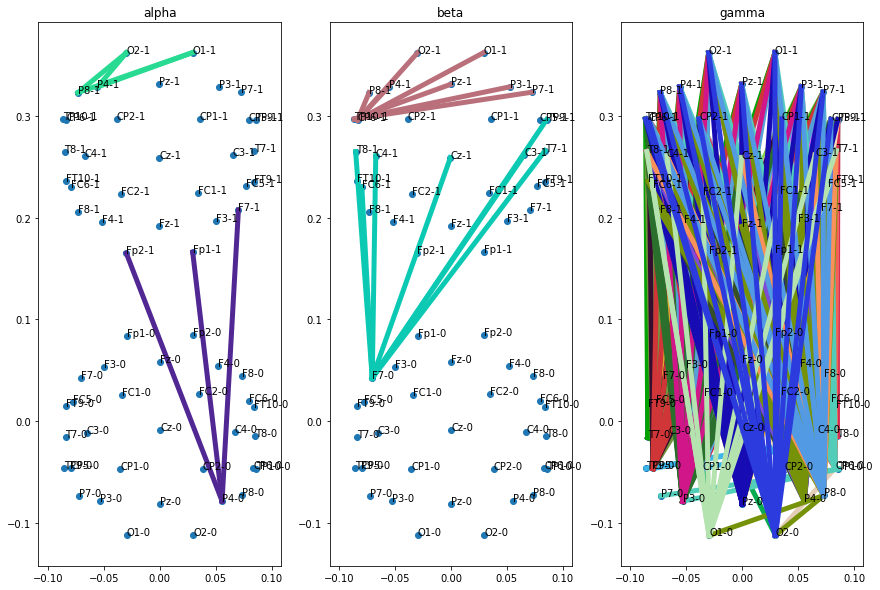

In [16]:
l = []
sensloc = np.array([c['loc'][:3] for c in combinedBaseline.info['chs']][:62])
plt.figure(figsize=[20,10])
for f_idx, f_lab in enumerate(frequencies_labels):
    cluster_pv = cluster_pvList[f_idx]
    clusters = clustersList[f_idx]
    assert len(cluster_pv) == len(clusters)
    plt.subplot(1,4,f_idx+1)
    plt.scatter(sensloc[:, 0], sensloc[:, 1])
    #Add channels' name
    for i, txt in enumerate(combinedBaseline.info["ch_names"]):
        plt.annotate(combinedBaseline.info["ch_names"][i], (sensloc[i, 0], sensloc[i, 1]))
    #Plot significant connections
    if len(cluster_pv) > 0:
        for cl_idx, cluster in enumerate(clusters):
            if cluster_pv[cl_idx] < pvalue:
#                print(cl_idx, cluster_pv[cl_idx])
                color = np.random.rand(3)
                for ne, (e1,e2) in enumerate(electrodes):
                    if cluster[0][ne]:
                        l.append([f_lab, ne, (e1,e2)])
                        plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1],
                                 sensloc[e2, 1]), linewidth=5, color=color)
        plt.title(f_lab)

**Calculating permutation *with clusters***

**BUG? - I'm not sure the clusters are actually calculated well***

In [17]:
fobsList = []
clustersList = []
cluster_pvList = []
H0List = []
pvalue = 0.05
for f_idx, f_lab in enumerate(frequencies_labels):
    print(f_idx, f_lab)
    data1 = vectconn[np.argwhere(grps==1), f_idx, :]
    data2 = vectconn[np.argwhere(grps==2), f_idx, :]
    data3 = vectconn[np.argwhere(grps==3), f_idx, :]
    data4 = vectconn[np.argwhere(grps==4), f_idx, :]
    data5 = vectconn[np.argwhere(grps==5), f_idx, :]
    data6 = vectconn[np.argwhere(grps==6), f_idx, :]
    romantic = np.concatenate([data1, data2], axis = 0)
    goodFriends = np.concatenate([data3, data4], axis = 0)
    strangers = np.concatenate([data5, data6], axis = 0)
    Fobs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(X=[romantic, strangers, goodFriends],
                                                                        tail=0,
                                                                        n_permutations = 1000,
                                                                        seed = 42, 
                                                                        step_down_p = pvalue,
                                                                        connectivity = lil_matrix(metaconn), 
                                                                        check_disjoint = False)
    fobsList.append(Fobs)
    clustersList.append(clusters)
    cluster_pvList.append(cluster_pv)
    H0List.append(H0)

0 alpha


<ipython-input-17-581e87b07188>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.000012 max=16.716287
Running initial clustering
Found 2 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
1 beta


<ipython-input-17-581e87b07188>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.000110 max=13.907695
Running initial clustering
Found 2 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
2 gamma


<ipython-input-17-581e87b07188>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  check_disjoint = False)


Using a threshold of 3.062700
stat_fun(H1): min=0.000648 max=19.980765
Running initial clustering
Found 1 clusters
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 999 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.


**How many p-values I have for each band**

Notice the huge difference! Wasn’t it supposed to be the other way around?

In [18]:
for c, p in enumerate(cluster_pvList):
    print("for freq", frequencies_labels[c], "I have" , len([pv for pv in p if pv < pvalue]), "pvs")

for freq alpha I have 1 pvs
for freq beta I have 1 pvs
for freq gamma I have 1 pvs


Graphing the significant connections

**BUG? - for some odd reason it gives me all the connections**

As if one cluster includes all the channels

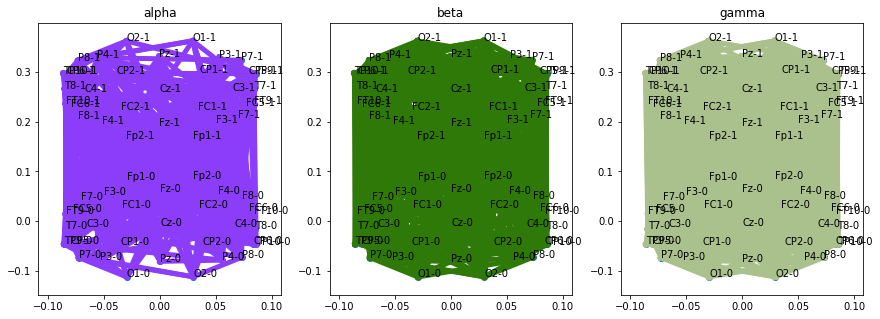

In [19]:
l = []
sensloc = np.array([c['loc'][:3] for c in combinedBaseline.info['chs']][:62])
plt.figure(figsize=[20,5])
for f_idx, f_lab in enumerate(frequencies_labels):
    cluster_pv = cluster_pvList[f_idx]
    clusters = clustersList[f_idx]
    assert len(cluster_pv) == len(clusters)
    plt.subplot(1,4,f_idx+1)
    plt.scatter(sensloc[:, 0], sensloc[:, 1])
    #Add channels' name
    for i, txt in enumerate(combinedBaseline.info["ch_names"]):
        plt.annotate(combinedBaseline.info["ch_names"][i], (sensloc[i, 0], sensloc[i, 1]))
    #Plot significant connections
    if len(cluster_pv) > 0:
        for cl_idx, cluster in enumerate(clusters):
            if cluster_pv[cl_idx] < pvalue:
#                print(cl_idx, cluster_pv[cl_idx])
                color = np.random.rand(3)
                for ne, (e1,e2) in enumerate(electrodes):
                    if cluster[0][ne]:
                        l.append([f_lab, ne, (e1,e2)])
                        plt.plot((sensloc[e1, 0], sensloc[e2, 0]), (sensloc[e1, 1],
                                 sensloc[e2, 1]), linewidth=5, color=color)
        plt.title(f_lab)